# Statistical Analysis

After cleaning the data, the next step is to analyze variables for statistically significant relationships. Prior to building models, categorical variables will be converted using label encoder or one-hot encoder.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import norm, t, chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from numpy.random import seed
from sklearn.preprocessing import LabelEncoder

In [2]:
# import data
data = pd.read_csv('tree_census_stat_ready.csv', index_col=0, encoding='utf-8')

tree = data.copy()

In [3]:
tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 651535 entries, 0 to 651534
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   tree_id       651535 non-null  int64  
 1   tree_dbh      651535 non-null  int64  
 2   curb_loc      651535 non-null  object 
 3   health        651535 non-null  object 
 4   spc_common    651535 non-null  object 
 5   steward       651535 non-null  object 
 6   guards        651535 non-null  object 
 7   sidewalk      651535 non-null  object 
 8   problems      651535 non-null  object 
 9   root_stone    651535 non-null  object 
 10  root_grate    651535 non-null  object 
 11  root_other    651535 non-null  object 
 12  trunk_wire    651535 non-null  object 
 13  trnk_light    651535 non-null  object 
 14  trnk_other    651535 non-null  object 
 15  brch_light    651535 non-null  object 
 16  brch_shoe     651535 non-null  object 
 17  brch_other    651535 non-null  object 
 18  boro

In [4]:
tree.head()

,tree_id,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,problems,root_stone,...,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,180683,3,OnCurb,Fair,red maple,None,None,NoDamage,None,No,...,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,200540,21,OnCurb,Fair,pin oak,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,None,No,...,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,204337,10,OnCurb,Good,honeylocust,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,189565,21,OnCurb,Good,American linden,None,None,Damage,Stones,Yes,...,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


In [5]:
# find categorial variables
tree.select_dtypes(include='object').columns

Index(['curb_loc', 'health', 'spc_common', 'steward', 'guards', 'sidewalk',
       'problems', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other',
       'borough'],
      dtype='object')

In [6]:
# number of unique trees
print('Number of unique trees:', len(tree.spc_common.unique()))

Number of unique trees: 132


Since there are so many tree species in NYC, the variable will be dropped since it is difficult to encode all of them.

In [7]:
# remove columns
col_remove = ['tree_id', 'problems', 'spc_common']

tree.drop(col_remove, axis=1, inplace=True)

# cleaned up dataset
tree.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,3,OnCurb,Fair,None,None,NoDamage,No,No,No,No,No,No,No,No,No,Queens,-73.844215,40.723092,0
1,21,OnCurb,Fair,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Queens,-73.818679,40.794111,1
2,3,OnCurb,Good,1or2,None,Damage,No,No,No,No,No,No,No,No,No,Brooklyn,-73.936608,40.717581,0
3,10,OnCurb,Good,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,-73.934456,40.713537,1
4,21,OnCurb,Good,None,None,Damage,Yes,No,No,No,No,No,No,No,No,Brooklyn,-73.975979,40.666778,1


# Statistical Testing - Chi-Square Test for Association

We use the chi-square test for association to determine any statistical significance between variables.

## Curb Location (curb_loc)

In [8]:
# p-value: 0.05
curb_loc_table = pd.crosstab(tree.curb_loc, [tree.health])
display(curb_loc_table)

health,Fair,Good,Poor
curb_loc,,,
OffsetFromCurb,4022,20814,963
OnCurb,92405,507513,25818


In [9]:
# chi-square test - reject null hypothesis
chisq_value, pvalue, df, expected = chi2_contingency(curb_loc_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue)

Chi-square value:  21.208951781289166
p-value:  2.4804737603349355e-05


## Stewardship

In [10]:
# p-value: 0.05
steward_table = pd.crosstab(tree.steward, [tree.health])
display(steward_table)

health,Fair,Good,Poor
steward,,,
1or2,21883,115231,6276
3or4,2829,15594,747
4orMore,200,1360,49
None,71515,396142,19709


In [11]:
# using a shortcut, chi2_contingency
chisq_value, pvalue, df, expected = chi2_contingency(steward_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject null hypothesis

Chi-square value:  82.64204316499212
p-value:  1.0158580809907348e-15


## Guards

In [12]:
# p-value: 0.05
guard_table = pd.crosstab(tree.guards, [tree.health])
display(guard_table)

health,Fair,Good,Poor
guards,,,
Harmful,3836,15313,1091
Helpful,7159,42602,2061
None,84057,464503,23169
Unsure,1375,5909,460


In [13]:
chisq_value, pvalue, df, expected = chi2_contingency(guard_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject null hypothesis

Chi-square value:  575.1113270237256
p-value:  5.43997022022521e-121


## Sidewalk

In [14]:
# p-value: 0.05
sidewalk_table = pd.crosstab(tree.sidewalk, [tree.health])
display(sidewalk_table)

health,Fair,Good,Poor
sidewalk,,,
Damage,28676,151750,6593
NoDamage,67751,376577,20188


In [15]:
chisq_value, pvalue, df, expected = chi2_contingency(sidewalk_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject null hypothesis

Chi-square value:  268.98082116629007
p-value:  3.9044225721239635e-59


## Borough

In [16]:
# p-value: 0.05
borough_table = pd.crosstab(tree.borough, tree.health)
display(borough_table)

health,Fair,Good,Poor
borough,,,
Bronx,10879,66546,3092
Brooklyn,25060,138119,6454
Manhattan,11456,47338,3607
Queens,34512,193789,9401
Staten Island,14520,82535,4227


In [17]:
chisq_value, pvalue, df, expected = chi2_contingency(borough_table)

print('Chi-square value: ', chisq_value)
print('p-value: ', pvalue) # safe to reject null hypothesis

Chi-square value:  1387.3756826254964
p-value:  3.0368189425788952e-294


## root_stone, root_grate, root_other, trunk_wire, trnk_light, trnk_other, brch_light, brch_shoe, brch_other

In [18]:
# these 9 columns are similar to each other (binaries) so we are creating a function to handle all of them at once
root_trunk_branch = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

rt_tk_bh_values = []

for x in root_trunk_branch:
    table = pd.crosstab(tree[x], [tree.health])
    chisq_value, pvalue, df, expected = chi2_contingency(table)
    rt_tk_bh_values.extend(('Column: ' + x, 'Chi-square: ', chisq_value, 'p-value:', pvalue, '-----------'))

In [19]:
display(rt_tk_bh_values)

['Column: root_stone',
 'Chi-square: ',
 602.1719849387213,
 'p-value:',
 1.7378604199012528e-131,
 '-----------',
 'Column: root_grate',
 'Chi-square: ',
 356.68976230775087,
 'p-value:',
 3.5140039001739447e-78,
 '-----------',
 'Column: root_other',
 'Chi-square: ',
 1928.3000460610629,
 'p-value:',
 0.0,
 '-----------',
 'Column: trunk_wire',
 'Chi-square: ',
 511.1079115744369,
 'p-value:',
 1.0335397233161574e-111,
 '-----------',
 'Column: trnk_light',
 'Chi-square: ',
 42.65188376759023,
 'p-value:',
 5.473449537752943e-10,
 '-----------',
 'Column: trnk_other',
 'Chi-square: ',
 11787.16656714847,
 'p-value:',
 0.0,
 '-----------',
 'Column: brch_light',
 'Chi-square: ',
 410.2875656415676,
 'p-value:',
 8.07582918010992e-90,
 '-----------',
 'Column: brch_shoe',
 'Chi-square: ',
 35.43604272124426,
 'p-value:',
 2.01911517512005e-08,
 '-----------',
 'Column: brch_other',
 'Chi-square: ',
 15111.455650416505,
 'p-value:',
 0.0,
 '-----------']

The p-values all show that there is statistical significance between each of the nine columns and tree health.

# Statistical Testing - Analysis of Variance (ANOVA)

The goal of using an ANOVA test is to look for differences in average diameters between groups of good, fair, and poor trees. To do that, we use a N-way ANOVA test, where N=3.

## Diameter Distributions

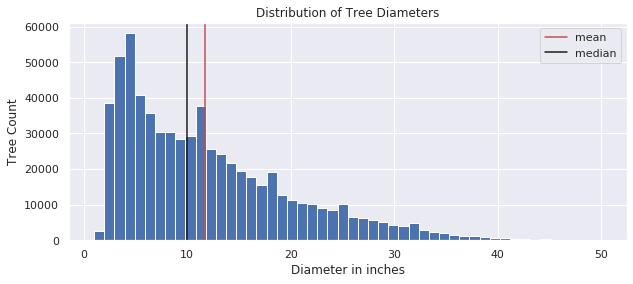

In [20]:
plt.figure(figsize=(10, 4))
tree.tree_dbh.hist(bins=50)
plt.xlabel('Diameter in inches')
plt.ylabel('Tree Count')
plt.title('Distribution of Tree Diameters')
plt.axvline(np.mean(tree.tree_dbh), color='r', label='mean')
plt.axvline(np.median(tree.tree_dbh), color='k', label='median')
plt.legend()
plt.show()

In [21]:
# stats
tree.tree_dbh.describe()

count    651535.000000
mean         11.674665
std           8.366295
min           1.000000
25%           5.000000
50%          10.000000
75%          16.000000
max          50.000000
Name: tree_dbh, dtype: float64

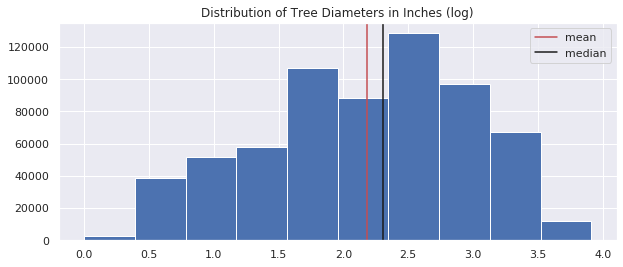

In [22]:
# take the log of tree_dbh
dbh_log = np.log(tree.tree_dbh)

plt.figure(figsize=(10, 4))
dbh_log.hist()
plt.title('Distribution of Tree Diameters in Inches (log)')
plt.axvline(np.mean(dbh_log), color='r', label='mean')
plt.axvline(np.median(dbh_log), color='k', label='median')
plt.legend()
plt.show() # the distribution appears closer to normal after taking the log

Taking the log of the diameters, the distribution is slightly skewed to the left but is closer to a normal distribution than previously.

In [23]:
tree.groupby('health')['tree_dbh'].describe()

,count,mean,std,min,25%,50%,75%,max
health,,,,,,,,
Fair,96427.0,10.954370,7.61766,1.0,5.0,9.0,15.0,50.0
Good,528327.0,11.942466,8.53741,1.0,5.0,10.0,17.0,50.0
Poor,26781.0,8.985064,6.74574,1.0,4.0,7.0,12.0,50.0


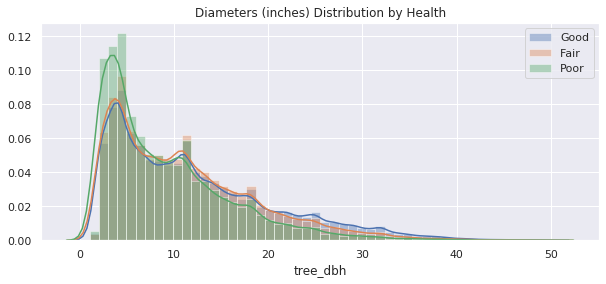

In [24]:
# group diameters according to tree health
health_good = tree[tree.health == 'Good']['tree_dbh']
health_fair = tree[tree.health =='Fair']['tree_dbh']
health_poor = tree[tree.health == 'Poor']['tree_dbh']

# plotting the distribution of diameters
plt.figure(figsize=(10, 4))
sns.distplot(health_good, label='Good')
sns.distplot(health_fair, label='Fair')
sns.distplot(health_poor, label='Poor')
plt.title('Diameters (inches) Distribution by Health')
plt.legend()
plt.show()

In [25]:
# compute 95% confidence intervals
conf_int_good = np.percentile(health_good, [2.5, 97.5])
conf_int_fair = np.percentile(health_fair, [2.5, 97.5])
conf_int_poor = np.percentile(health_poor, [2.5, 97.5])

# where do 95% of trees belong?
print('Good trees:', conf_int_good)
print('Fair trees:', conf_int_fair)
print('Poor trees:', conf_int_poor)

Good trees: [ 2. 33.]
Fair trees: [ 2. 30.]
Poor trees: [ 2. 26.]


In [26]:
# multiple hypothesis testing - fail to reject null hypothesis
stats.f_oneway(health_good, health_fair, health_poor)

F_onewayResult(statistic=2024.439439934227, pvalue=0.0)

In [27]:
diam_health = ols('tree_dbh ~ health', data=tree).fit()
dh_table = sm.stats.anova_lm(diam_health, typ=2)

display(dh_table)

,sum_sq,df,F,PR(>F)
health,2.816514e+05,2.0,2024.43944,0.0
Residual,4.532240e+07,651532.0,NaN,NaN


## Analyzing Problems Distribution

We use a 2-sample t-test in order to determine any significance between two population means.

In [28]:
pd.crosstab(tree.health, [tree.num_problems])

num_problems,0,1,2,3,4,5,6,7,8,9
health,,,,,,,,,,
Fair,53915,27984,10436,3275,717,84,15,1,0,0
Good,356491,127845,34377,8011,1479,105,18,1,0,0
Poor,15486,6579,2901,1414,324,59,16,0,1,1


In [29]:
# group according to tree health
probs_good = tree[tree.health == 'Good']['num_problems']
probs_fair = tree[tree.health =='Fair']['num_problems']
probs_poor = tree[tree.health == 'Poor']['num_problems']

# compute 95% confidence intervals
cprobs_good = np.percentile(probs_good, [2.5, 97.5])
cprobs_fair = np.percentile(probs_fair, [2.5, 97.5])
cprobs_poor = np.percentile(probs_poor, [2.5, 97.5])

# where do 95% of trees belong?
print('Good trees:', cprobs_good)
print('Fair trees:', cprobs_fair)
print('Poor trees:', cprobs_poor)

Good trees: [0. 2.]
Fair trees: [0. 3.]
Poor trees: [0. 3.]


In [30]:
# multiple hypothesis testing
stats.f_oneway(probs_good, probs_fair, probs_poor)

F_onewayResult(statistic=4433.764048871619, pvalue=0.0)

In [31]:
probs_health = ols('num_problems ~ health', data=tree).fit()
ph_table = sm.stats.anova_lm(probs_health, typ=2)

display(ph_table)

,sum_sq,df,F,PR(>F)
health,4980.080714,2.0,4433.764049,0.0
Residual,365906.023830,651532.0,NaN,NaN


# Encoding Categorical Data

We'll start by looking at the root, trunk, and branch columns. Since each of these columns contain simple Yes or No options, we create a new column with labels indicating **0 for No and 1 for Yes**.

In [32]:
# convert columns to binary
cols_transform = ['curb_loc', 'sidewalk', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

for col in cols_transform:
    tree[col].replace({'Yes': 1, 'No':0}, inplace=True)

In [33]:
# curb_loc and sidewalk conversion
tree['curb_loc'].replace({'OnCurb': 1, 'OffsetFromCurb':0}, inplace=True)

tree['sidewalk'].replace({'Damage': 1, 'NoDamage':0}, inplace=True)

In [34]:
tree.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,borough,longitude,latitude,num_problems
0,3,1,Fair,None,None,0,0,0,0,0,0,0,0,0,0,Queens,-73.844215,40.723092,0
1,21,1,Fair,None,None,1,1,0,0,0,0,0,0,0,0,Queens,-73.818679,40.794111,1
2,3,1,Good,1or2,None,1,0,0,0,0,0,0,0,0,0,Brooklyn,-73.936608,40.717581,0
3,10,1,Good,None,None,1,1,0,0,0,0,0,0,0,0,Brooklyn,-73.934456,40.713537,1
4,21,1,Good,None,None,1,1,0,0,0,0,0,0,0,0,Brooklyn,-73.975979,40.666778,1


## Dummy Variables

Nominal categorical variables require dummy variables. Since steward and guards have a similar response, None, each will be outfitted so as to distinguish their origins.

In [35]:
# remove ID from Region
tree.loc[:, 'steward'] = tree.steward.str.replace('None', 'Stew_N')
tree.loc[:, 'guards'] = tree.guards.str.replace('None', 'Guard_N')

In [36]:
# convert using get_dummies
steward_dum = pd.get_dummies(tree.steward)
guards_dum = pd.get_dummies(tree.guards)
borough_dum = pd.get_dummies(tree.borough)

In [37]:
tree = pd.concat([tree, steward_dum, guards_dum, borough_dum], axis=1)

tree.head()

,tree_dbh,curb_loc,health,steward,guards,sidewalk,root_stone,root_grate,root_other,trunk_wire,...,Stew_N,Guard_N,Harmful,Helpful,Unsure,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,3,1,Fair,Stew_N,Guard_N,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,21,1,Fair,Stew_N,Guard_N,1,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,3,1,Good,1or2,Guard_N,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,10,1,Good,Stew_N,Guard_N,1,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0
4,21,1,Good,Stew_N,Guard_N,1,1,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [38]:
# drop original categorical columns
tree.drop(['steward', 'guards', 'borough'], axis=1, inplace=True)

In [39]:
tree.head()

,tree_dbh,curb_loc,health,sidewalk,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,...,Stew_N,Guard_N,Harmful,Helpful,Unsure,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,3,1,Fair,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,21,1,Fair,1,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,3,1,Good,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,10,1,Good,1,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0
4,21,1,Good,1,1,0,0,0,0,0,...,1,1,0,0,0,0,1,0,0,0


In [40]:
tree.shape

(651535, 29)

# Correlations

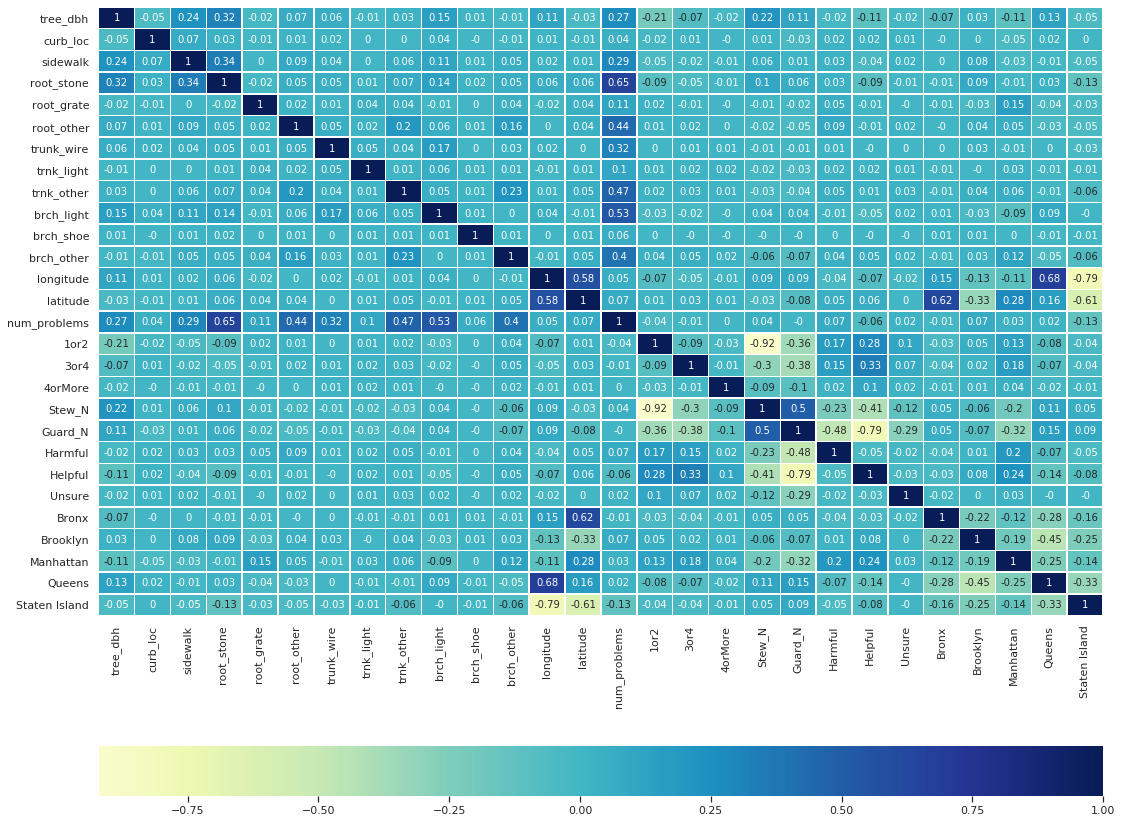

In [41]:
# remove target variable, health
tree_corr = tree.drop(columns='health')

plt.figure(figsize=(18, 16))
sns.heatmap(tree_corr.corr().round(2), center=0, cmap='YlGnBu', linewidths=.5, annot=True, cbar_kws={'orientation': 'horizontal'})
plt.show()

There is a strong inverse correlation between steward_none and 1or2. The majority of trees do not have a steward and the second most popular option is 1 to 2 stewards, which could explain the strong correlation.

# Next Steps

In [42]:
# save for machine learning
# tree.to_csv('tree_ml.csv')